# Computational Intelligence - Homework 3

#### Ali Asghar Kerai - ak06857
#### Muhammad Jazzel Mehmood - mm06886

We have used two approaches for plotting the world map and colouring it according to the clusters.
- In the first approach, after using SOM to make clusters we tried to group all the states according to the countries. The data for confirmed COVID patients, the number of patients recovered, and number of deaths were summed up. Then using geopandas library we plotted the world map. Thus we had coloured the world map according to the countries however we faced issues such as different naming convention of library and no data of few countries such as Antartica we decided to move to second approach.
- In second approach we used the information of longitudes and latitudes by using API and geoencoding library got very accurate information such as city, state, country. Now we had accurate names of all the countries, so we merged the data country wise and by using weights assigned color to it which was plotted to world map.



### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import geopandas as gpd
import requests
import time


### Reading & Normalizing Data

In [2]:
data = pd.DataFrame()
def read_normalize_data():
    # Reading data from csv
    data = pd.read_csv('Q1_countrydata.csv')

    data = data.drop(['Last_Update'], axis=1) #dropping information of data updating dates
    data = data.drop(['Province_State'], axis=1) #dropping province state column

    countries = []
    processed_data = []
    for idx, row in data.iterrows():
        country = row['Country_Region']
        if country in countries:
            continue
        countries.append(country)
        country_data = data[data["Country_Region"] == country]

        processed_country_data = {
            "country": country,
            "lat": [],
            "long": [],
            "confirmed": 0,
            "deaths": 0,
            "recovered": 0,
        }
        for country_idx, country_row in country_data.iterrows():
            lat = country_row['Lat']
            long = country_row['Long_']
            confirmed = country_row['Confirmed']
            deaths = country_row['Deaths']
            recovered = country_row['Recovered']

            processed_country_data["lat"].append(lat)
            processed_country_data["long"].append(long)
            processed_country_data["confirmed"] += confirmed
            processed_country_data["deaths"] += deaths
            processed_country_data["recovered"] += recovered
        
        processed_data.append(processed_country_data)

    data = pd.DataFrame(processed_data)


    # # # Converting deaths and recovered to ratios
    data['deaths'] = data['deaths'] / data['confirmed']
    data['recovered'] = data['recovered'] / data['confirmed']

    # log scaling the confirmed, deaths and recovered columns
    data['confirmed'] = np.log(data['confirmed'] + 1)
    data['deaths'] = np.log(data['deaths'] + 1)
    data['recovered'] = np.log(data['recovered'] + 1)

    # # # Normalize confirmed, deaths and recovered columns with max value
    data['confirmed'] = data['confirmed'] / data['confirmed'].max()
    data['deaths'] = data['deaths'] / data['deaths'].max()
    data['recovered'] = data['recovered'] / data['recovered'].max()

    data["color"] = None

    # # Whenever the longitude and latitude information is not provided then we drop that row
    data = data.dropna(subset=['lat', 'long'])

    return data

### SOM 

In [3]:
# Generic class for training SOM
class SOM: 
    def __init__(self, learning_decay_rate, radius_decay_rate, iterations, weights, grid, nodes, data):
        self.learning_decay_rate = learning_decay_rate
        self.radius_decay_rate = radius_decay_rate
        self.iterations = iterations
        self.weights = weights
        self.grid = grid
        self.nodes = nodes
        self.data = data
        self.iteration = 0 #initializing iteration to 0

    def run(self):
        learning_decay = self.learning_decay_rate #updating learning decay rate
        radius_decay = self.radius_decay_rate #updating radius decay rate

        print("SOM Training Started")
        self.plot() #initial SOM plot
        for i in range(1, self.iterations + 1): #running the loop according to number of iterations
            self.iteration = i
            random_row = self.data.sample() #selecting a random input node/vector from the data

            index = random_row.index.values[0]
            random_row = random_row.to_numpy()
            country, lat, long, confirmed, deaths, recovered, color = random_row[0].tolist() #extracting the values from the input node
            bmu, index_bmu = self.get_bmu({"confirmed": confirmed, "deaths": deaths, "recovered": recovered}) #finding BMU

            for index in range(self.nodes): #updating the weights of the nodes
                twod_index = np.unravel_index(index, (self.grid, self.grid))
                distance_to_bmu = pow((twod_index[0] - index_bmu[0])**2 + (twod_index[1] - index_bmu[1])**2, 1/2) #euclidean distance between BMU and the node
                if distance_to_bmu < radius_decay: #if the distance is less than the radius decay then update the weights
                    theta = math.exp(-((distance_to_bmu**2)/(2*(radius_decay**2)))) #neighbourhood function
                    self.weights[index] = self.weights[index] + learning_decay * theta * ([confirmed * 0.7, deaths * 0.7, recovered * 0.7, 1] - self.weights[index]) #weights updated

            learning_decay = self.learning_decay_rate * math.exp((-i/self.iterations)) #updating learning decay rate
            radius_decay = self.radius_decay_rate * math.exp((-i/self.iterations)) #updating radius decay rate

        print("SOM Training Finished")
        # self.normalize_weights()
        self.plot() #plotting SOM after training

    def get_distance(self, sample, weight): #helper function for calculating euclidean distance between the input node and the weight
        return pow((weight[0] - sample["confirmed"])**2 + (weight[1] - sample["deaths"])**2 + (weight[2] - sample["recovered"])**2, 1/2)

    def get_diff_array(self, sample):  #helper function for calculating the difference between the input node and the weights
        return [self.get_distance(sample, weight) for weight in self.weights]
        
    def get_bmu(self, sample): #helper function for finding the BMU (shortest distance between the input node and the weights)
        diff_array = self.get_diff_array(sample)
        bmu = min(diff_array)
        index_bmu = np.unravel_index(diff_array.index(bmu), (self.grid, self.grid))
        return bmu, index_bmu
    
    def normalize_weights(self): #normalizing the weights
        for index in range(self.nodes):
            self.weights[index] = self.weights[index] / np.linalg.norm(self.weights[index])

    def plot(self): #for plotting the SOM
        fig, ax = plt.subplots()
        for i in range(self.grid):
            for j in range(self.grid):
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color=self.weights[i*10+j]))
        plt.axis('scaled')
        plt.title(f'SOM - Iteration: {self.iteration}')
        plt.show()

    def assign_colors_to_states(self): #assign colors to the states according to the weights
        for index, row in self.data.iterrows():
            country, lat, long, confirmed, deaths, recovered, color = row
            bmu, index_bmu = self.get_bmu({"confirmed": confirmed, "deaths": deaths, "recovered": recovered}) #finding BMU
            color = self.weights[index_bmu[0]*10 + index_bmu[1]] 
            self.data.at[index, 'color'] = list(color) #colour of BMU is updated to the state
        return self.data

In [4]:
data = read_normalize_data() #reading and normalizing the data
data #printing data below for visual observation

data.describe()

,confirmed,deaths,recovered
count,191.000000,191.000000,191.000000
mean,0.603282,0.080509,0.818472
std,0.180671,0.099447,0.214798
min,0.041164,0.000000,0.000000
25%,0.507208,0.036229,0.789933
50%,0.635469,0.065850,0.869871
75%,0.725739,0.099910,0.948174
max,1.000000,1.000000,1.000000


In [5]:
iterations = 4000 #number of iterations chosen
learning_decay_rate = 0.2 #initial learning decay rate
radius_decay_rate = 5 #initial radius decay rate

grid = 10 #grid size given
grid_size = (grid, grid)
sub_grid_size = grid//2 #sub grid size given initially for raduis for finding neighbours
nodes = grid * grid

weights = np.random.rand(nodes, 4) * 0.9 + 0.1 # initializing weights randomly

som = SOM(iterations=iterations, learning_decay_rate=learning_decay_rate, radius_decay_rate=radius_decay_rate, weights=weights, grid=grid, nodes=nodes, data=data)

### Running SOM

SOM Training Started


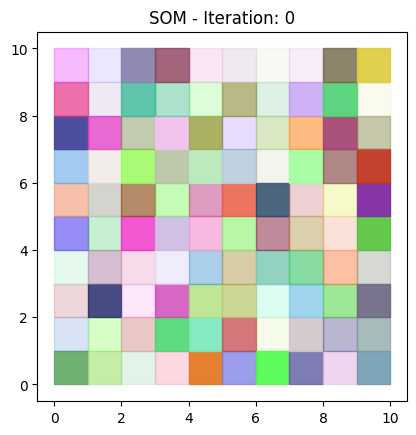

SOM Training Finished


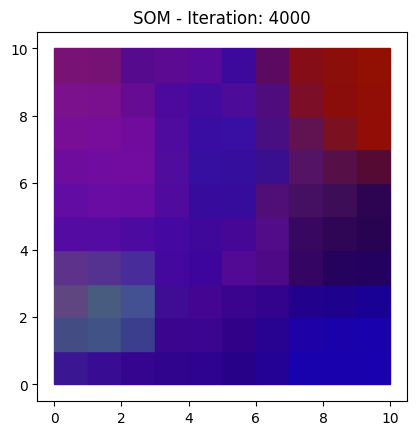

In [6]:
som.run()

### Assigning colors to states

In [7]:
# assigning colors to states
colored_data = som.assign_colors_to_states()
colored_data.head()

,country,lat,long,confirmed,deaths,recovered,color
0,Afghanistan,[33.93911],[67.709953],0.644347,0.163367,0.855850,"[0.4466341643201883, 0.046660423926489836, 0.6..."
1,Albania,[41.1533],[20.1683],0.652382,0.078350,0.662062,"[0.47016936907149093, 0.05099052973400432, 0.6..."
2,Algeria,[28.0339],[1.6596],0.683820,0.106984,0.744193,"[0.47016936907149093, 0.05099052973400432, 0.6..."
3,Andorra,[42.5063],[1.5218],0.534955,0.040148,0.936524,"[0.410771036858117, 0.04692958665163106, 0.644..."
4,Angola,[-11.2027],[17.8739],0.580583,0.089647,0.709687,"[0.47016936907149093, 0.05099052973400432, 0.6..."


### Plotting map

- Without fixing country names

C:\Users\Jezzel\AppData\Local\Temp\ipykernel_10800\2618412941.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) #reading the world map


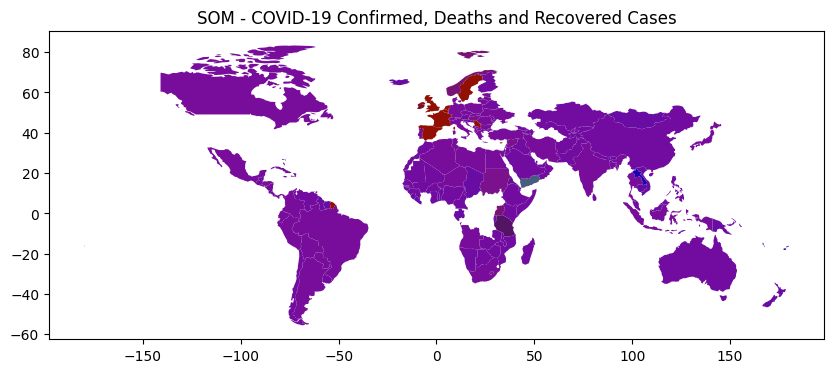

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) #reading the world map
world = world.merge(colored_data, left_on='name', right_on='country') #coloring the world map based on country names we were provided
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color=world['color'], legend=True) #plotting the world map
plt.title('SOM - COVID-19 Confirmed, Deaths and Recovered Cases')
plt.show()


- With fixing country names

C:\Users\Jezzel\AppData\Local\Temp\ipykernel_10800\2381159314.py:22: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


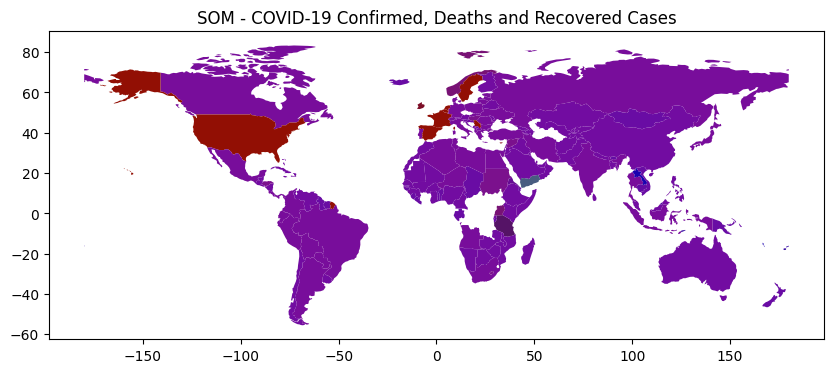

In [9]:
# Fixing country names in colored data

fixed_data = colored_data.copy()

fixed_data = fixed_data.replace({'country': {
    'United States': 'United States of America',
    'Czechia': 'Czech Republic',
    'Bosnia and Herz.': 'Bosnia and Herzegovina',
    'Central African Rep.': 'Central African Republic',
    'Dem. Rep. Congo': 'Democratic Republic of the Congo',
    'Dominican Rep.': 'Dominican Republic',
    'Eq. Guinea': 'Equatorial Guinea',
    'eSwatini': 'Eswatini', 
    "Russian Federation": "Russia",
    'Solomon Is.': 'Solomon Islands', 
    'S. Sudan': 'South Sudan', 
    'Trinidad and Tobago': 'Trinidad & Tobago', 
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland', 
    'United Rep. of Tanzania': 'United Republic of Tanzania', 
    'Vatican': 'Vatican City'}})

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.merge(fixed_data, left_on='name', right_on='country')

fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color=world['color'], legend=True)
plt.title('SOM - COVID-19 Confirmed, Deaths and Recovered Cases')
plt.show()
